In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import os
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

from scripts.countries import ENERGY_CRISIS
from scripts.causal_graphs import GRAPH18,GRAPH22
from scripts.utils import scale_font_latex
from scripts.evaluate_causal_results import compare_coefficients, compare_r2_scores
from scripts.causal_plots import plot_coefficients, plot_evaluation_results_custom

## Load data

In [2]:
# load data for FR
TRUE_END = pd.Timestamp("20231231T23", tz="utc")
TRUE_START = pd.Timestamp("20180101T00", tz="utc")
true_years = f"{TRUE_START.year}-{TRUE_END.year}"
COUNTRY_CODE = "FR"


total_data = (
    pd.read_csv(
        f"../data/processed/combined_data/data_selected_{COUNTRY_CODE}_{true_years}.csv",
        parse_dates=["timestamp"],
    )
    .set_index("timestamp")
    .rename(columns={"nuclear_avail": "na", "ramperation_da": "gen_da_ramp"})
)

# convert hour, season, month to cyclical value for linear regression
total_data.loc[:, "hour_sin"] = np.sin(total_data.loc[:, "hour"] * (2.0 * np.pi / 24))
total_data.loc[:, "hour_cos"] = np.cos(total_data.loc[:, "hour"] * (2.0 * np.pi / 24))
total_data.loc[:, "day_of_year_sin"] = np.sin(
    (total_data.loc[:, "day_of_year"] - 1) * (2.0 * np.pi / 365)
)
total_data.loc[:, "day_of_year_cos"] = np.cos(
    (total_data.loc[:, "day_of_year"] - 1) * (2.0 * np.pi / 365)
)

ec_by_years = {"2018-2023": "total"}

# better xlabels
var_names = {
    "gas_price": "Gas price",
    "load_da": "Load day-ahead",
    "na": "Nuclear availability",
    "run_off_gen": "ROR generation",
    "price_da": "Price day-ahead",
    "agg_net_export": "Net exports",
    "river_flow_mean": "River flow rate",
    "river_temp": "River temperature",
    "rl_BE": "RL BE",
    "rl_DE_LU": "RL DE-LU",
    "rl_ES": "RL ES",
    "rl_FR_ramp": "RL ramp FR",
    "rl_IT_NORD": "RL IT-North",
    "solar_da": "Solar day-ahead",
    "temp_mean": "Air temperature",
    "wind_da": "Wind day-ahead",
    "carbon_price": "Carbon price",
}

# Functions for all models

In [3]:
def load_graph(selected_graph, target):
    """
    Load the graph and data for a specific target variable.
    Args:
        selected_graph (dict): The graph to load.
        target (str): The target variable.
    Returns:
        tuple: A tuple containing the data by time, directory, figure directory,
               coefficient comparison, R2 comparison, and graph name.
    """
    nodes = selected_graph["nodes"]
    causal_graph = selected_graph["graph"]
    name = selected_graph["name"]

    graph_data = total_data.loc[:, nodes].dropna()
    years = f"{graph_data.index[0].year}-{graph_data.index[-1].year}"

    data_by_time = {
        "before_ec": graph_data[:ENERGY_CRISIS],
        "during_ec": graph_data[ENERGY_CRISIS:],
        "total": graph_data,
    }

    dir = f"../models/{name}/"
    fig_dir = f"../reports/figures/model_evaluation/{name}/"
    try:
        os.makedirs(fig_dir, exist_ok=True)
    except:
        pass

    try:
        os.makedirs(fig_dir + f"coefficients/", exist_ok=True)
        os.makedirs(fig_dir + f"falsification/", exist_ok=True)
    except:
        pass

    var = target

    # structural coefficients
    coefficient_comparison = compare_coefficients(
        graph_name=name, var=var, years=ec_by_years.keys()
    ).rename(columns=ec_by_years)

    # r2 coefficients
    r2_comparison = compare_r2_scores(
        graph=selected_graph, years=ec_by_years.keys()
    ).rename(columns=ec_by_years)

    return (
        data_by_time,
        dir,
        fig_dir,
        coefficient_comparison,
        r2_comparison,
        name,
    )

In [9]:
def plot_total_coefficients(
    coefficient_comparison,
    data_by_time,
    unit,
    var_names,
    color,
    fig_dir,
    convert_to_GW=False,
):
    """
    Plot the total coefficients for a given variable.
    This function generates three plots:
    1. Structure coefficient times delta_x
    2. Structure coefficient times std
    3. All structure coefficients
    Each plot is saved as a PDF file in the specified directory.
    Args:
        coefficient_comparison (pd.DataFrame): The coefficient comparison DataFrame.
        data_by_time (dict): Dictionary containing data by time periods.
        unit (str): Unit for the y-axis label.
        var_names (dict): Dictionary mapping variable names to labels.
        color (str): Color for the plot.
        fig_dir (str): Directory to save the figures.
        convert_to_GW (bool): Whether to convert values to GW.
    """

    scale_font_latex(2)
    # plot structure coefficient times delta_x
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))

    df = coefficient_comparison.drop("intercept")
    df = df.rename(index=var_names)
    delta_x = (
        (data_by_time["during_ec"].mean() - data_by_time["before_ec"].mean())
        .rename(index=var_names)
        .loc[df.index]
    )

    for col in df.columns:
        df[col] *= delta_x
        if convert_to_GW:
            df[col] = df[col] / 1000
        plot_coefficients(df=df, col=col, ax=ax, color=color)
        ax.set_ylabel(r"$c_{ij} \cdot \Delta \overline{X_j} \;$" + unit)
        fig.savefig(
            fig_dir + f"coefficients/coefficients_delta_{col}.pdf", bbox_inches="tight"
        )
        plt.show()
        ax.cla()

    fig.clf()

    # plot structure coefficient times std
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))

    df = coefficient_comparison.drop("intercept")
    df = df.rename(index=var_names)

    for col in df.columns:
        df[col] *= data_by_time[col].std().rename(index=var_names).loc[df.index]
        if convert_to_GW:
            df[col] = df[col] / 1000
        plot_coefficients(df=df, col=col, ax=ax, color=color)
        ax.set_ylabel(r"$c_{ij} \cdot \sigma_{j} \;$" + unit)

        fig.savefig(
            fig_dir + f"coefficients/coefficients_std_{col}.pdf", bbox_inches="tight"
        )
        plt.show()
        ax.cla()

    fig.clf()

    # plot all strucutre coefficients
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))

    df = coefficient_comparison.drop("intercept")
    df.loc[["gas_price", "carbon_price"]] /= 100  # convert to MWh/100EUR
    df = df.rename(index=var_names)
    for col in df.columns:
        plot_coefficients(df=df, col=col, ax=ax, color=color)
        ax.set_ylabel(r"$c_{ij}$ (mixed units)")
        fig.savefig(
            fig_dir + f"coefficients/all_coefficients_{col}.pdf", bbox_inches="tight"
        )
        plt.show()
        ax.cla()

    fig.clf()

In [5]:
def plot_r2_scores(r2_comparison, color, fig_dir):
    """
    Plot the R2 scores for a given variable.
    This function generates a plot for each column in the R2 comparison DataFrame.
    Each plot is saved as a PDF file in the specified directory.
    Args:
        r2_comparison (pd.DataFrame): The R2 comparison DataFrame.
        color (str): Color for the plot.
        fig_dir (str): Directory to save the figures.
    """

    # r2-scores:

    scale_font_latex(2)

    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    df = r2_comparison

    df = df.rename(index=var_names)

    for col in df.columns:

        plot_coefficients(df=df, col=col, ax=ax, color=color)

        ax.set_ylabel("R2 score")

        fig.savefig(fig_dir + f"falsification/r2_scores_{col}.pdf", bbox_inches="tight")

        plt.show()

        ax.cla()
    fig.clf()

In [10]:
def plot_falsification_hist(dir, name, fig_dir):
    """
    Plot the falsification histogram for a given model.
    This function generates a histogram of the fraction of violations
    for different models and saves it as a PDF file in the specified directory.
    Args:
        dir (str): Directory containing the falsification data.
        name (str): Name of the model.
        fig_dir (str): Directory to save the figures.
    """

    # Falsification Histogram

    COLORS = list(mcolors.TABLEAU_COLORS.values())

    legend_elements = [
        Line2D(
            [0],
            [0],
            linestyle="--",
            color=COLORS[0],
            lw=1,
            label="Violations of TPa of given DAGs",
        ),
        Line2D(
            [0],
            [0],
            linestyle="--",
            color=COLORS[1],
            label="Violations of LMC of given DAGs",
        ),
        Patch(
            facecolor=COLORS[0],
            alpha=0.5,
            edgecolor="black",
            label="Violations of TPa of permuted DAGs",
        ),
        Patch(
            facecolor=COLORS[1],
            alpha=0.5,
            edgecolor="black",
            label="Violations of LMC of permuted DAGs",
        ),
    ]

    scale_font_latex(2.0)

    fig, ax = plt.subplots(1, 1, figsize=(16, 9), sharex=True)

    p_values = []

    for i, t in enumerate(ec_by_years.items()):

        year = t[0]

        with open(
            dir + f"falsification/{name}_{year}_falsification.pkl", "rb"
        ) as handle:

            falsification = pkl.load(handle)

        lable, p_value = plot_evaluation_results_custom(
            evaluation_result=falsification, ax=ax
        )

        p_values.append(p_value)

    ax.set_xlabel("Fraction of violations")

    ax.set_ylabel("# Permutations")

    fig.legend(
        loc="upper left",
        frameon=False,
        bbox_to_anchor=(0.0, 1.3),
        borderaxespad=0.0,
        handles=legend_elements,
    )

    fig.savefig(
        fig_dir + f"falsification/falsification_histogram_{name}_custom.pdf",
        bbox_inches="tight",
    )

    plt.show()
    fig.clf()

## Model18 for price_da as target

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


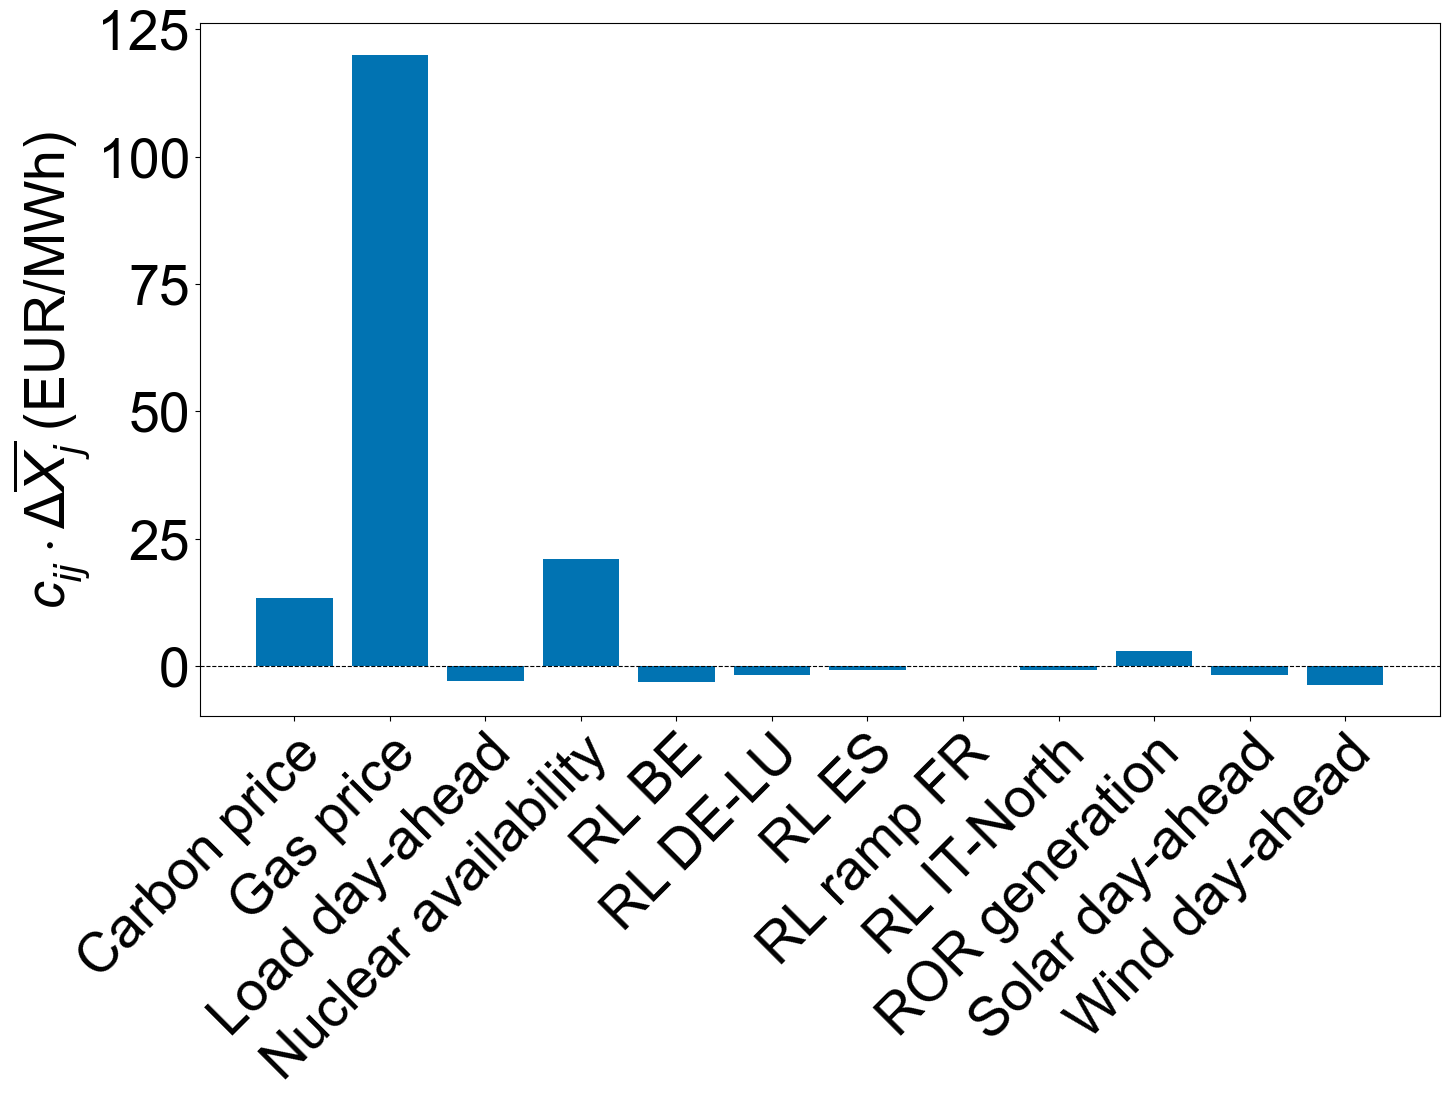

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


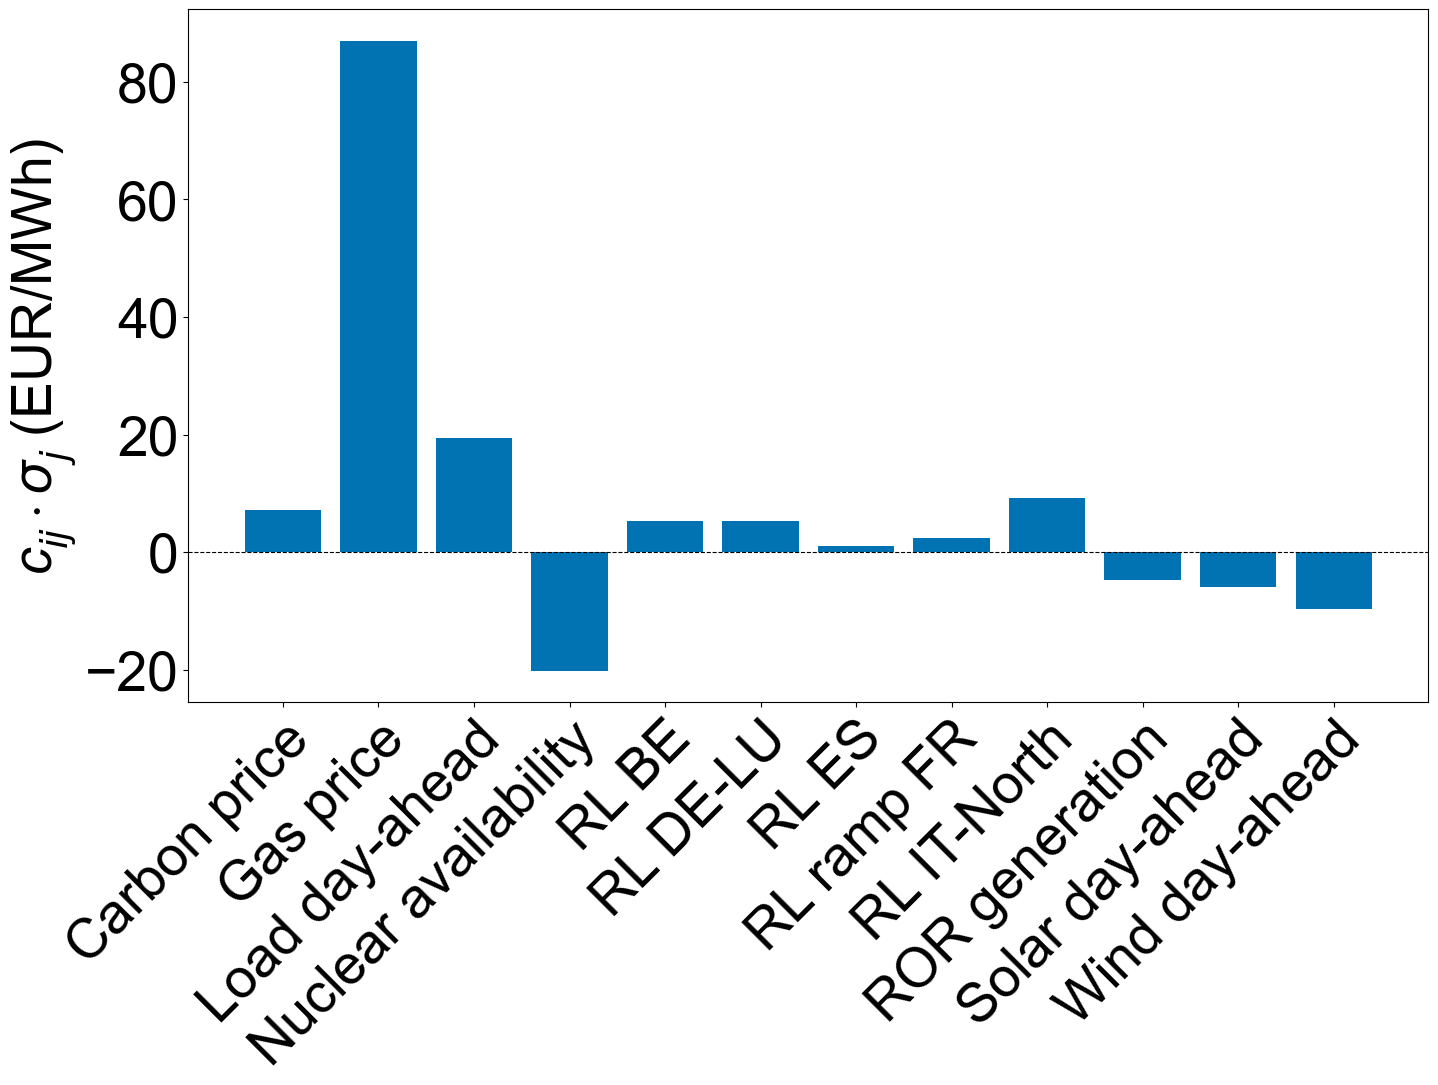

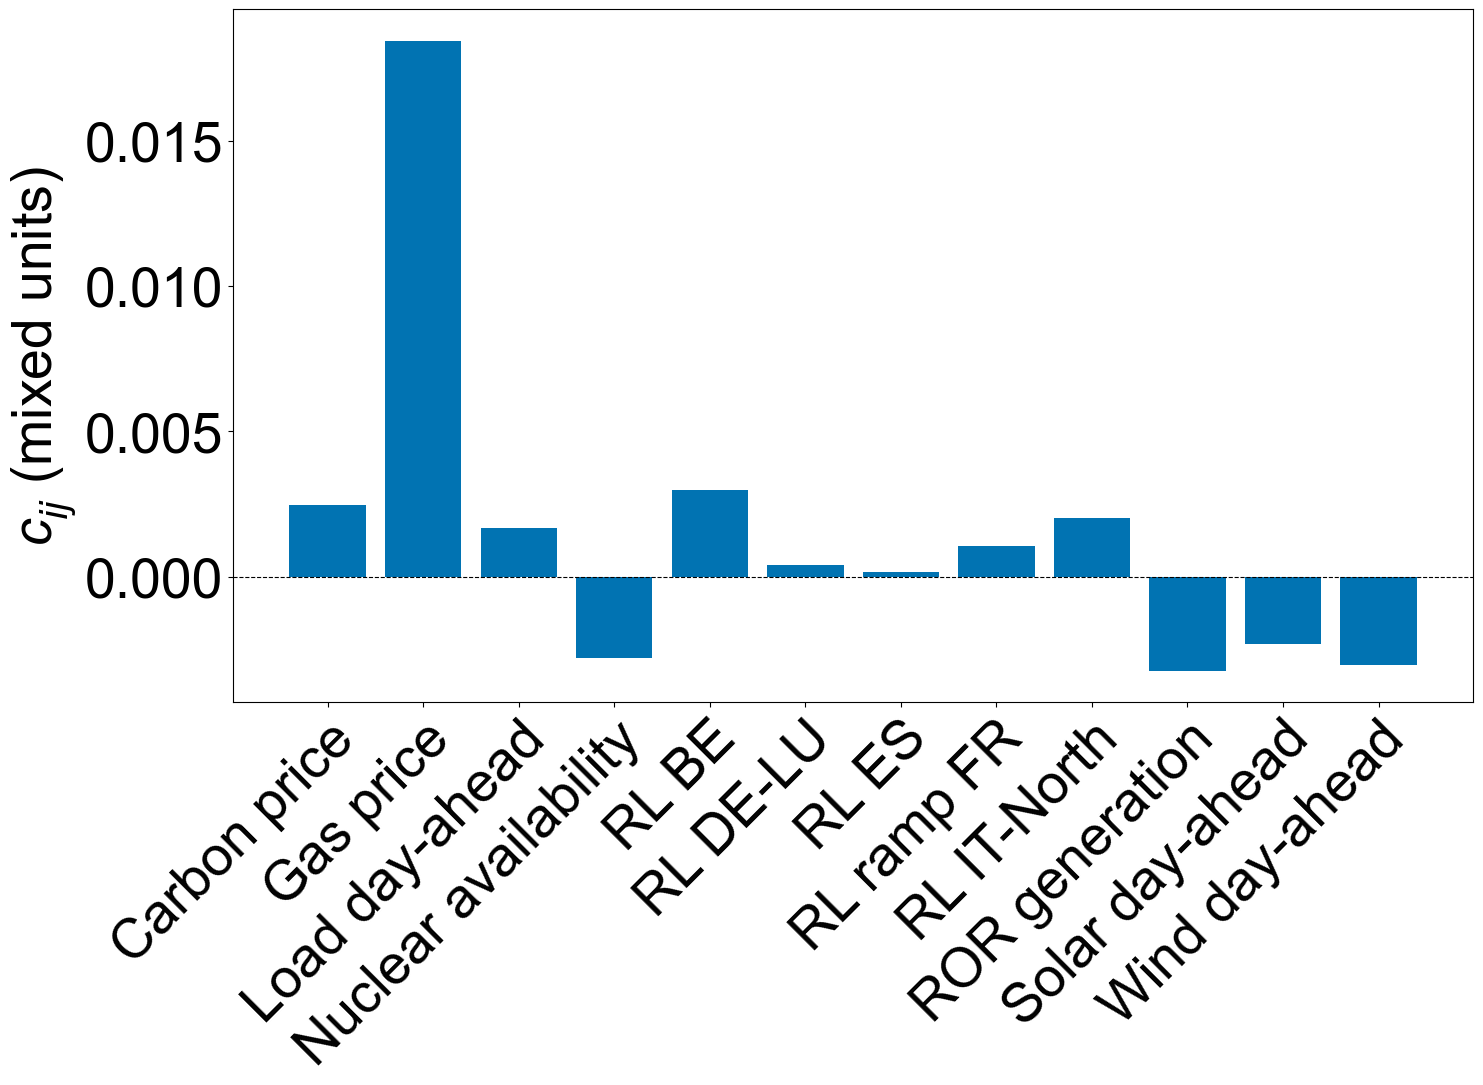

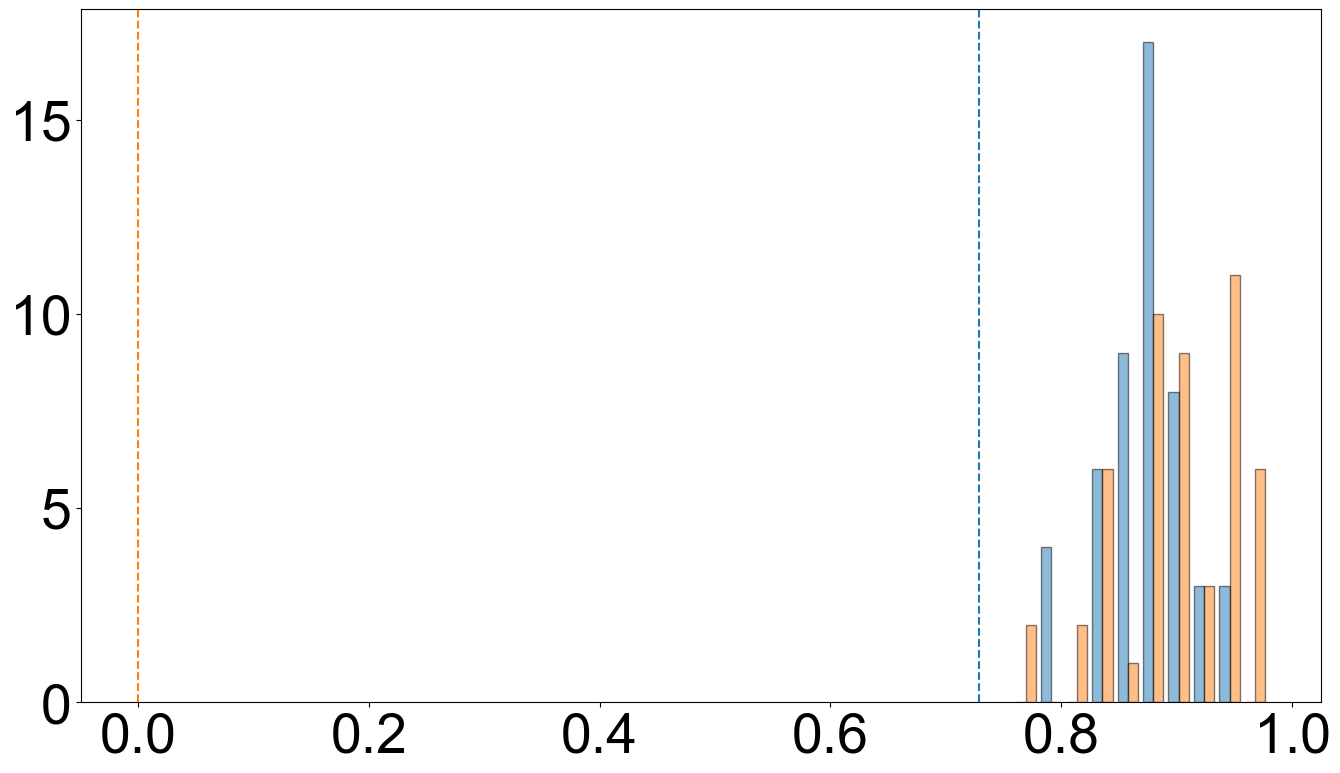

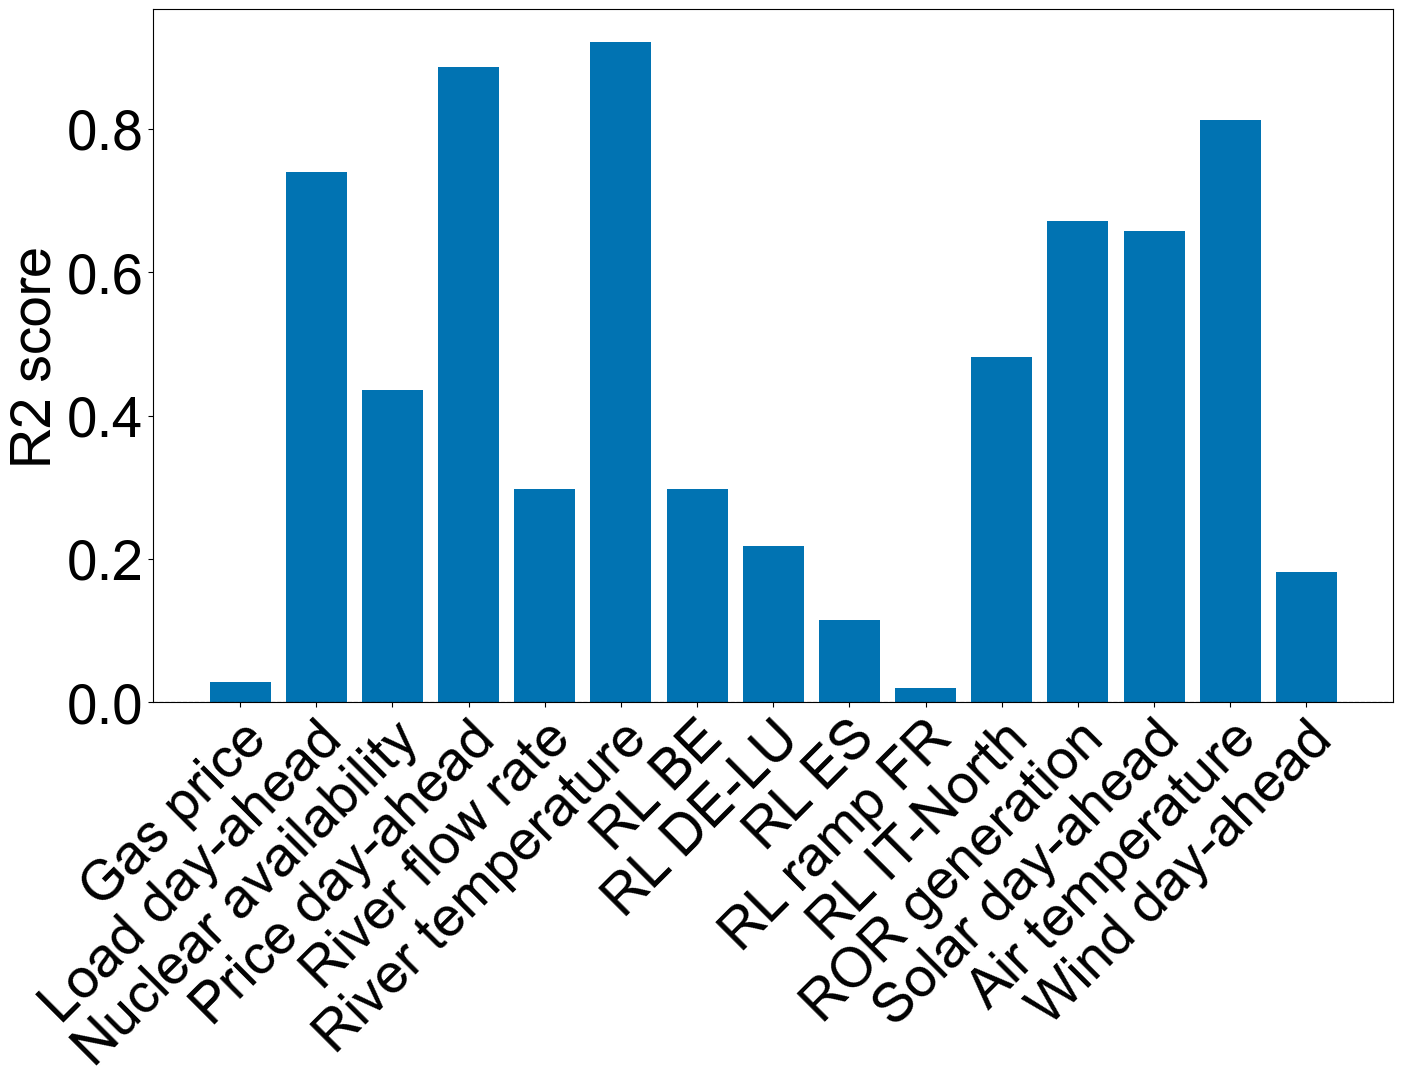

In [11]:
# select model. is only used to select correct nodes in data dataframe and load files created from 04-evaluate_scm notebook
(
    data_by_time,
    dir,
    fig_dir,
    coefficient_comparison,
    r2_comparison,
    name,
) = load_graph(GRAPH18, "price_da")
color = sns.color_palette("colorblind")[0]
plot_total_coefficients(
    coefficient_comparison=coefficient_comparison,
    data_by_time=data_by_time,
    unit="(EUR/MWh)",
    var_names=var_names,
    color=color,
    fig_dir=fig_dir,
)
plot_falsification_hist(dir, name, fig_dir=fig_dir)
plot_r2_scores(r2_comparison, color, fig_dir=fig_dir)

## Model22 for agg_net_export as target

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


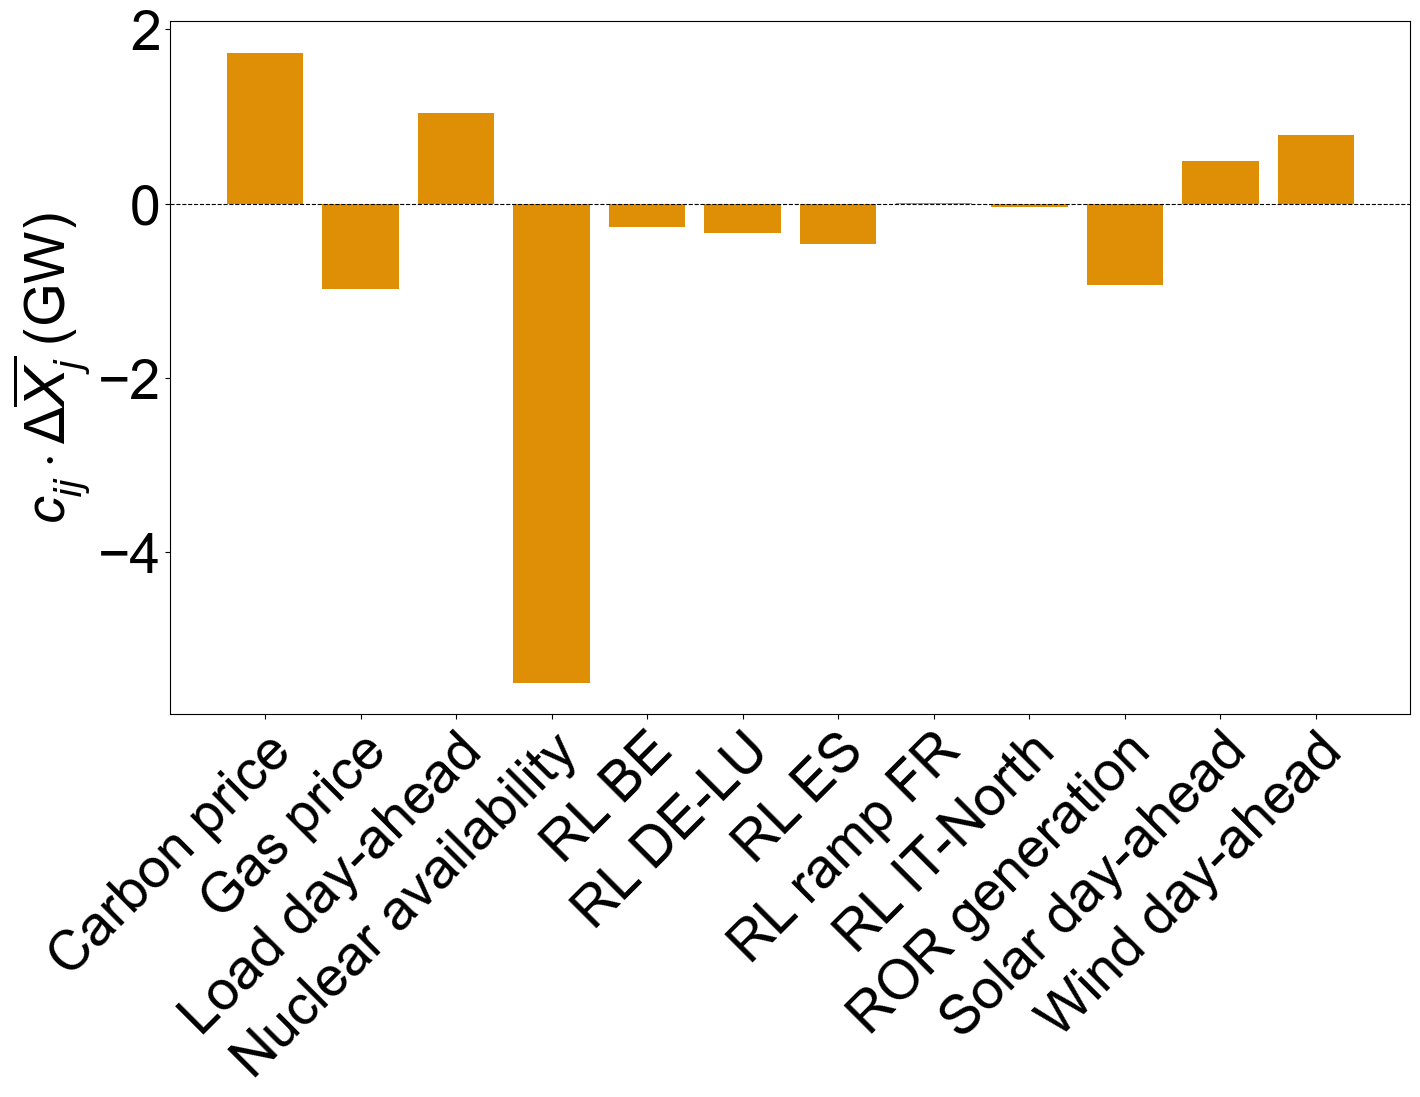

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


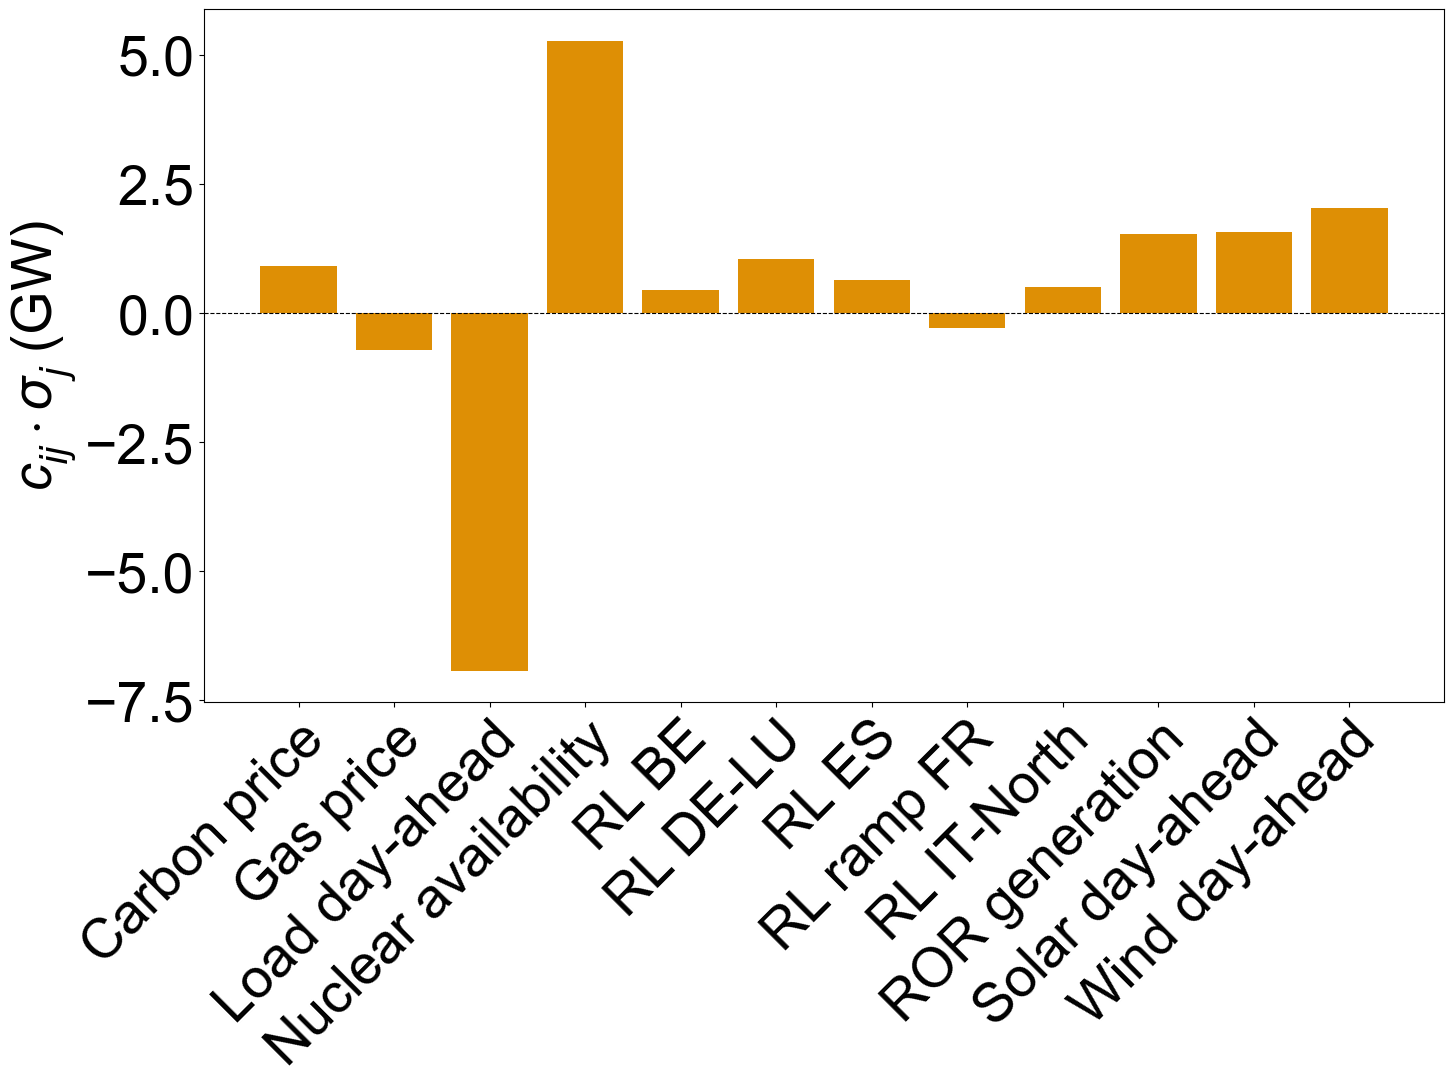

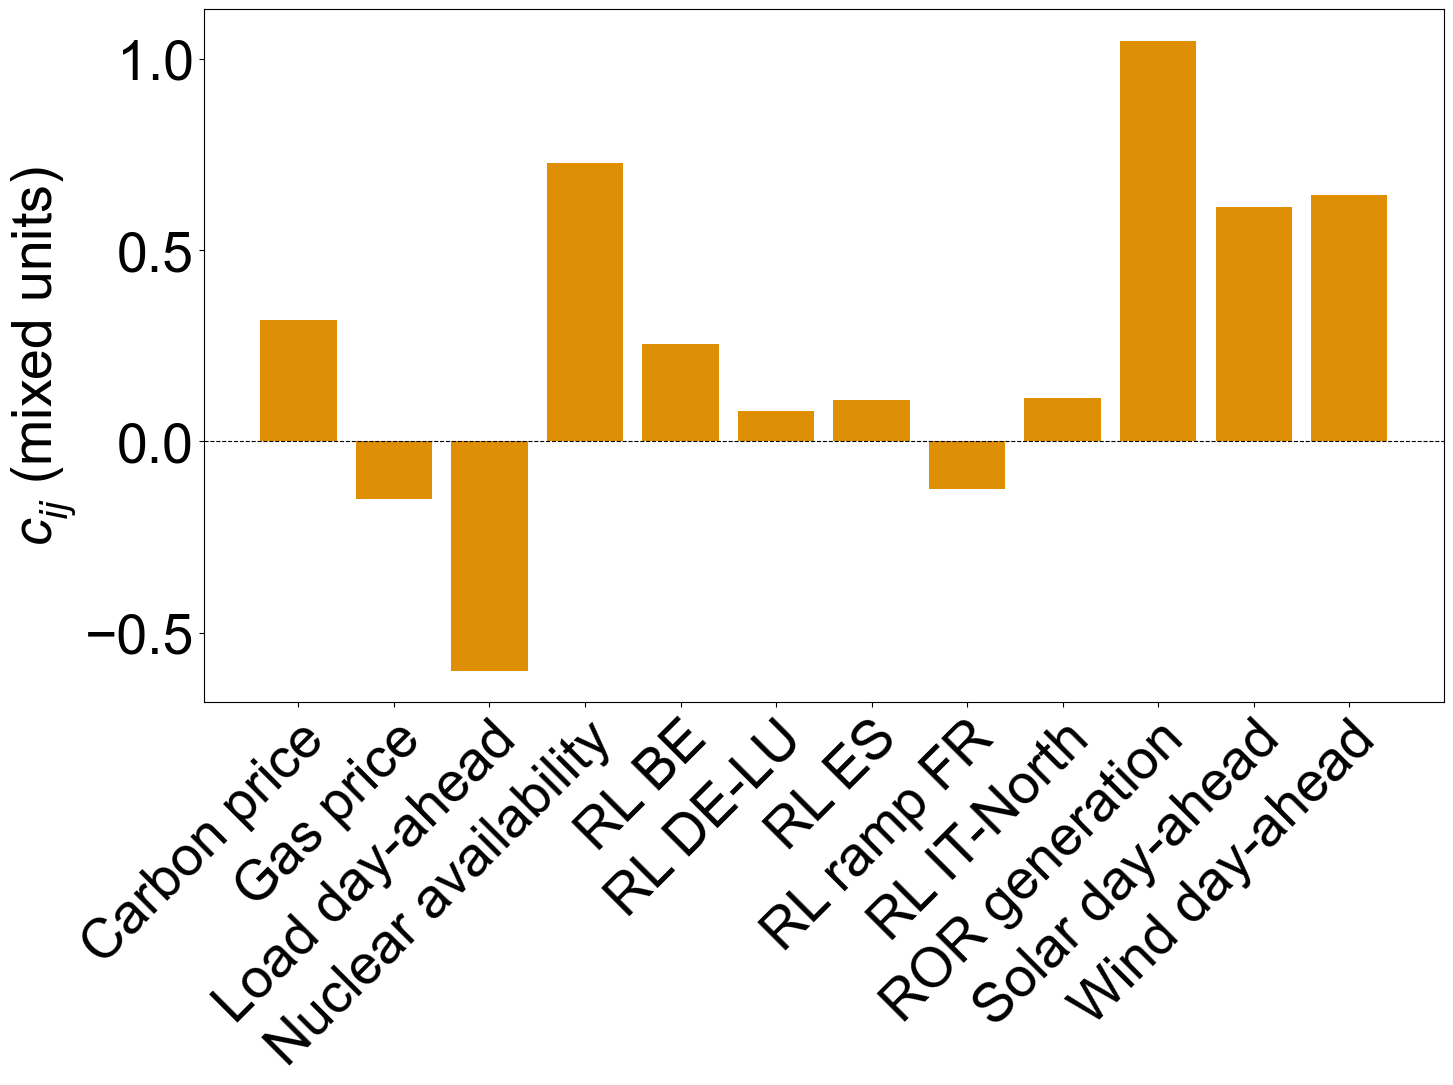

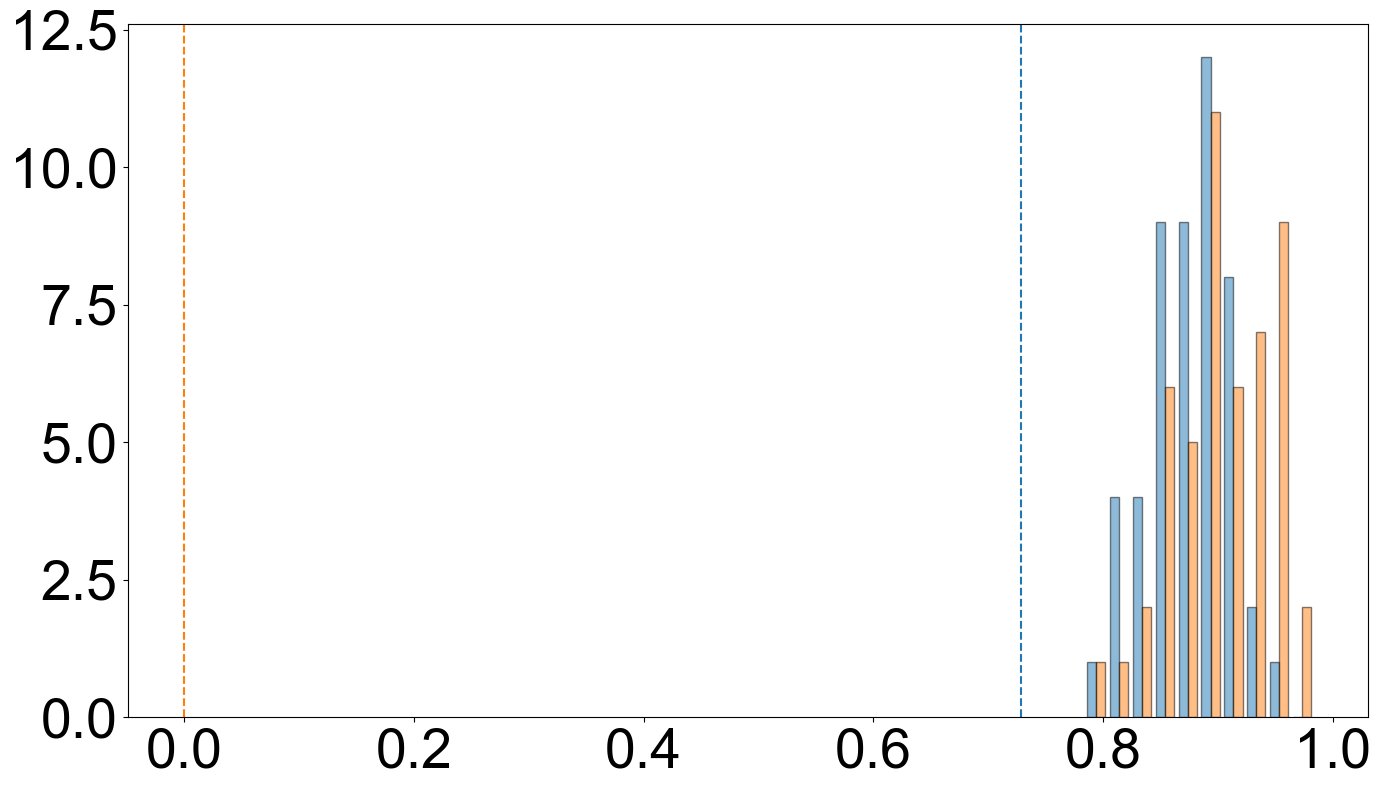

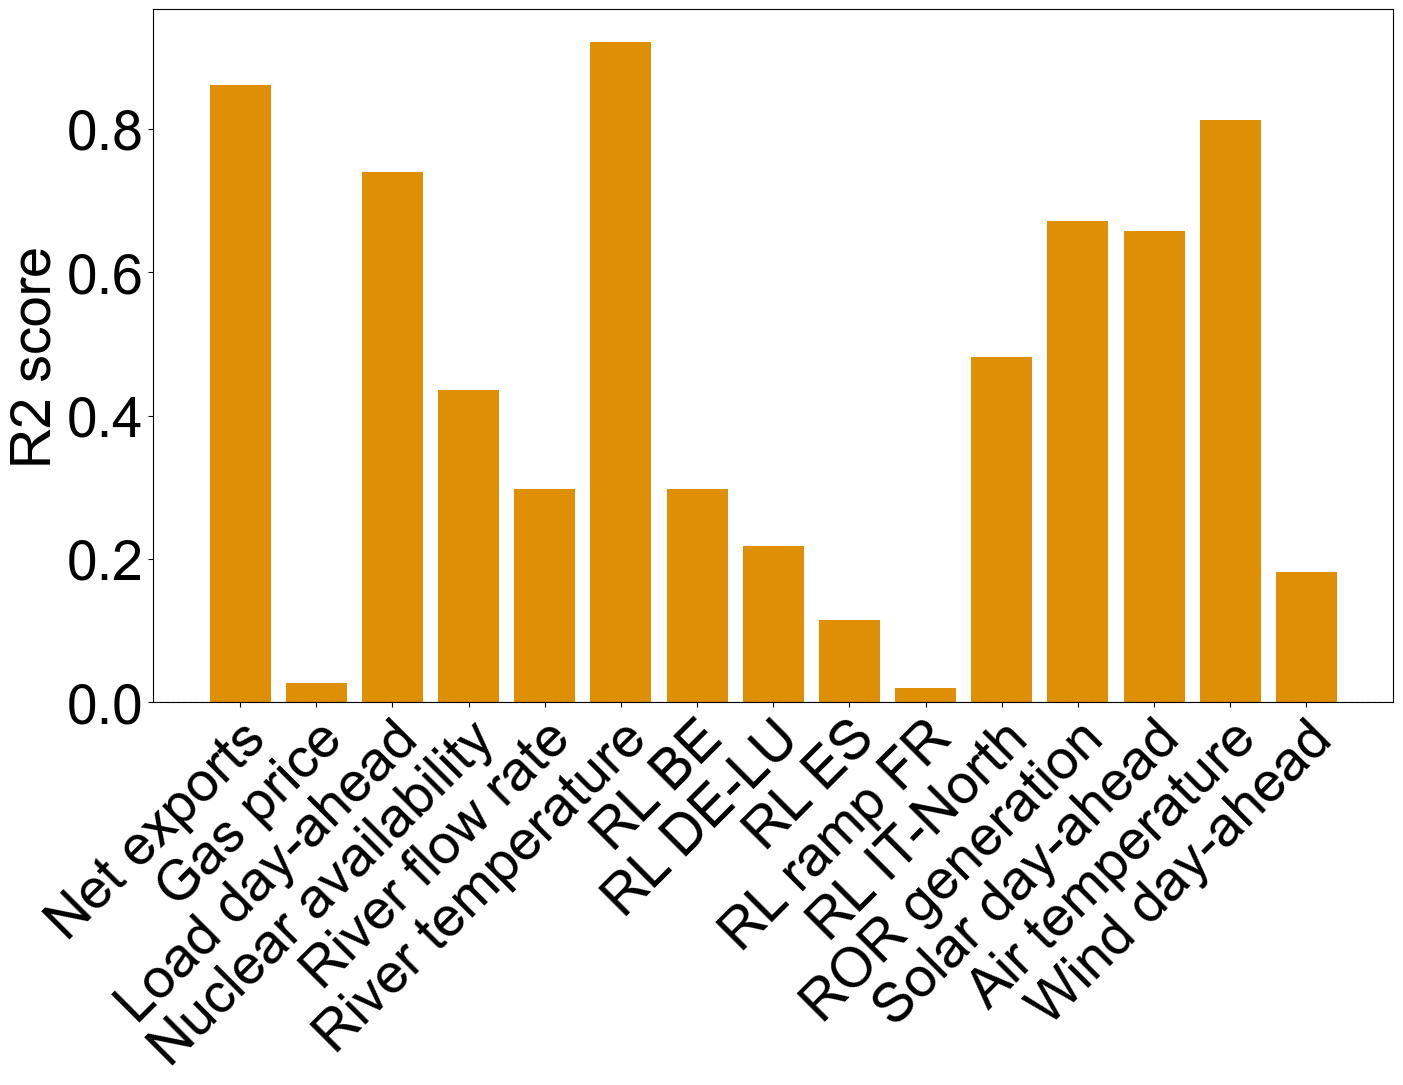

In [12]:
# select model. is only used to select correct nodes in data dataframe and load files created from 04-evaluate_scm notebook
(
    data_by_time,
    dir,
    fig_dir,
    coefficient_comparison,
    r2_comparison,
    name,
) = load_graph(GRAPH22, "agg_net_export")
color = sns.color_palette("colorblind")[1]
plot_total_coefficients(
    coefficient_comparison=coefficient_comparison,
    data_by_time=data_by_time,
    unit="(GW)",
    var_names=var_names,
    color=color,
    convert_to_GW=True,
    fig_dir=fig_dir,
)
plot_falsification_hist(dir, name, fig_dir=fig_dir)
plot_r2_scores(r2_comparison, color, fig_dir=fig_dir)